In [66]:
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import time

plt.style.use('ggplot')

def grt_query(query, endpoint):
    r = requests.post(endpoint, json={"query": query})
    return r.json().get("data", None)

In [93]:
ENDPOINT = "https://api.thegraph.com/subgraphs/id/QmT4AFRjFqXV9wupbBwvLGu1QrE3wedgE2j8PVuBD6HeeG"
QUERY = """
{
  revenueDailySnapshots(first: 1000 orderBy: timestamp orderDirection:desc) {
    crvRevenueToCallersAmount
    crvRevenueToPlatformAmount
    crvRevenueToCvxStakersAmount
    crvRevenueToLpProvidersAmount
    crvRevenueToCvxCrvStakersAmount
    totalCrvRevenue
    cvxRevenueToLpProvidersAmount
    cvxRevenueToCvxCrvStakersAmount
    fxsRevenueToCallersAmount
    fxsRevenueToPlatformAmount
    fxsRevenueToCvxStakersAmount
    fxsRevenueToLpProvidersAmount
    fxsRevenueToCvxFxsStakersAmount
    totalFxsRevenue
    bribeRevenue
    timestamp
  }
}
"""

In [94]:
data = grt_query(QUERY, ENDPOINT)

In [95]:
import pandas as pd
DAY = (60 * 60 * 24)
df = pd.DataFrame(data['revenueDailySnapshots'][1:])
df = df.astype(float)
df['timestamp'] = pd.to_datetime(df['timestamp'] // DAY * DAY,unit='s')

# Supply side revenue

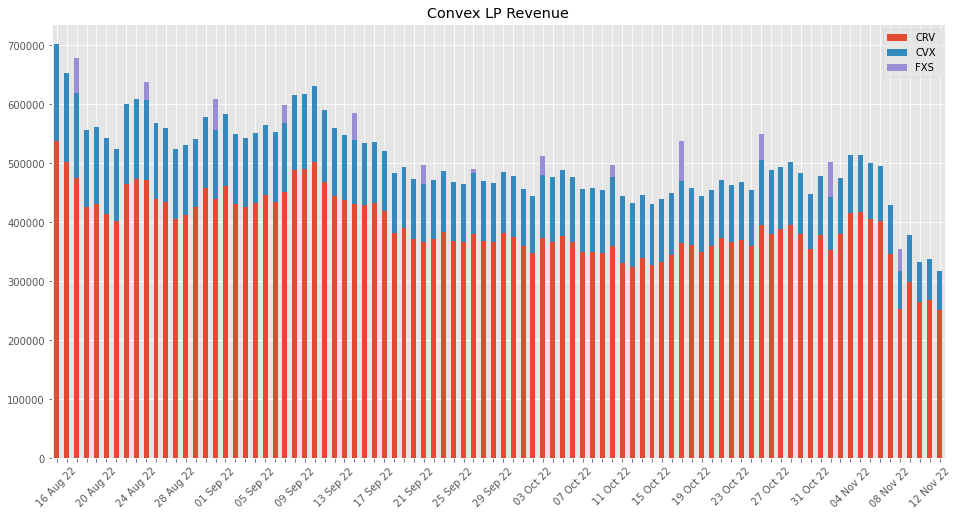

In [96]:
lp_rev = df[df['timestamp'] > max(df['timestamp']) - pd.Timedelta(days=90)][['crvRevenueToLpProvidersAmount', 'cvxRevenueToLpProvidersAmount', 'fxsRevenueToLpProvidersAmount', 'timestamp']].sort_values('timestamp', ascending=True)
lp_rev.columns = ['CRV', 'CVX', 'FXS', 'timestamp']
ax = lp_rev.plot.bar(x='timestamp', figsize=(16,8),  stacked=True, rot=45, title="Convex LP Revenue")
ticklabels = ['']*len(lp_rev['timestamp'])
ticklabels[::4] = [item.strftime('%d %b %y') for item in lp_rev['timestamp'][::4]]
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
ax.xaxis.get_label().set_visible(False)

# Holder Revenue

CRV directed to locked/staked CVX + Bribe revenue (minus Votium fee)

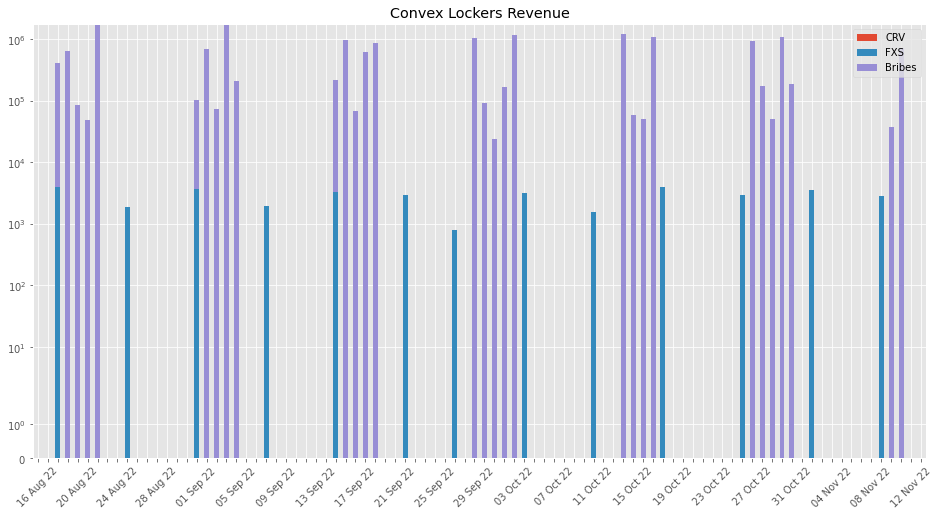

In [102]:
hodl_rev = df[df['timestamp'] > max(df['timestamp']) - pd.Timedelta(days=90)][['crvRevenueToCvxStakersAmount', 'fxsRevenueToCvxStakersAmount', 'bribeRevenue', 'timestamp']].sort_values('timestamp', ascending=True)
hodl_rev.columns = ['CRV', 'FXS', 'Bribes', 'timestamp']
ax = hodl_rev.plot.bar(x='timestamp', figsize=(16,8),  stacked=True, rot=45, title="Convex Lockers Revenue")
ticklabels = ['']*len(hodl_rev['timestamp'])
ticklabels[::4] = [item.strftime('%d %b %y') for item in hodl_rev['timestamp'][::4]]
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
ax.xaxis.get_label().set_visible(False)
ax.set_yscale('symlog')

# Daily Fees
Platform fees + Rewards to liquid lockers + Rewards to CVX holders

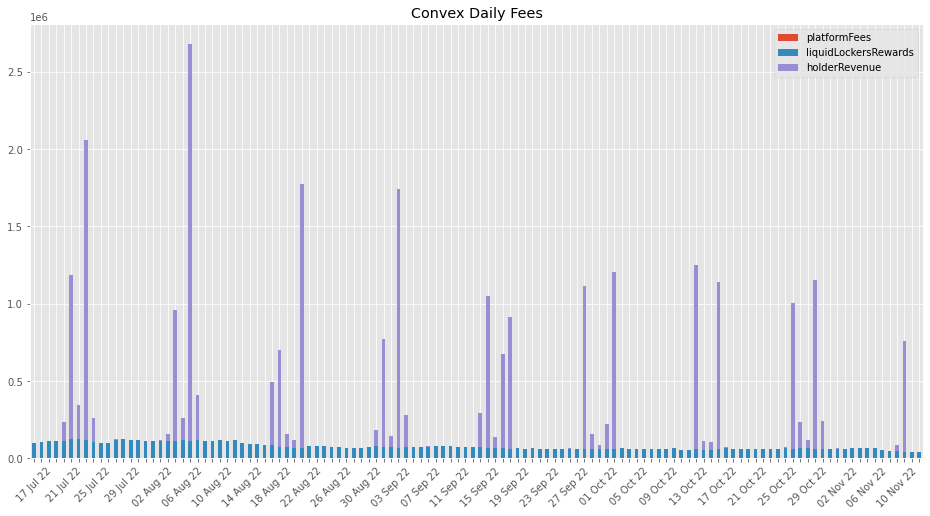

In [112]:
daily_fees = pd.DataFrame()
daily_fees['platformFees'] = df['fxsRevenueToPlatformAmount'] + df['crvRevenueToPlatformAmount']
daily_fees['liquidLockersRewards'] = df['crvRevenueToCvxCrvStakersAmount'] + df['fxsRevenueToCvxFxsStakersAmount'] + df['cvxRevenueToCvxCrvStakersAmount']
daily_fees['holderRevenue'] = df['crvRevenueToCvxStakersAmount'] + df['fxsRevenueToCvxStakersAmount'] + df['bribeRevenue']
daily_fees['timestamp'] = df['timestamp']

daily_fees = daily_fees[daily_fees['timestamp'] > max(df['timestamp']) - pd.Timedelta(days=120)].sort_values('timestamp', ascending=True)

ax = daily_fees.plot.bar(x='timestamp', figsize=(16,8),  stacked=True, rot=45, title="Convex Daily Fees")
ticklabels = ['']*len(daily_fees['timestamp'])
ticklabels[::4] = [item.strftime('%d %b %y') for item in daily_fees['timestamp'][::4]]
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
ax.xaxis.get_label().set_visible(False)

# Treasury Revenue

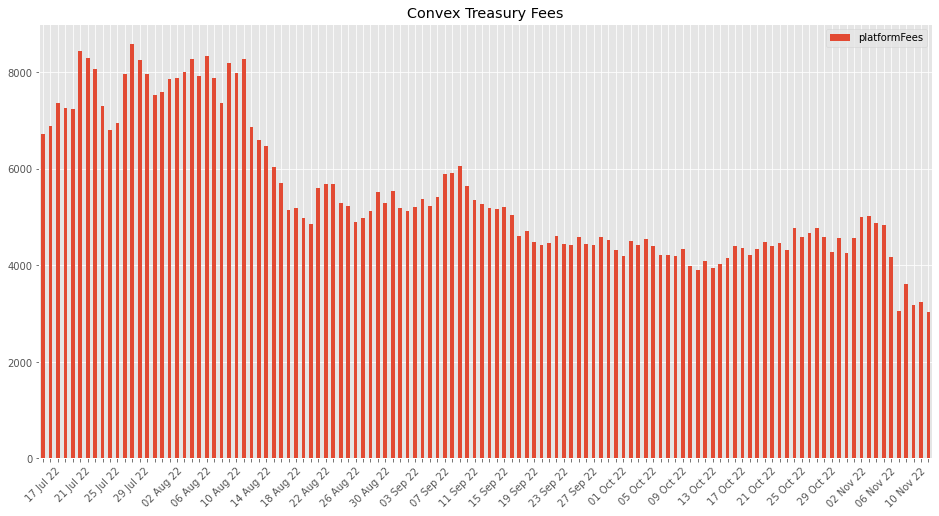

In [113]:
treasury = daily_fees[['platformFees', 'timestamp']]
treasury = treasury[treasury['timestamp'] > max(df['timestamp']) - pd.Timedelta(days=120)].sort_values('timestamp', ascending=True)

ax = treasury.plot.bar(x='timestamp', figsize=(16,8),  stacked=True, rot=45, title="Convex Treasury Fees")
ticklabels = ['']*len(treasury['timestamp'])
ticklabels[::4] = [item.strftime('%d %b %y') for item in treasury['timestamp'][::4]]
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
ax.xaxis.get_label().set_visible(False)